#### Task Details

What do we know about vaccines and therapeutics? <br> 
What has been published concerning research and development and evaluation efforts of vaccines and therapeutics?<br>
What proteins have been investigated?

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import string
from itertools import chain
from collections import Counter

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# ML
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE

# NLP
import spacy
import scispacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from scispacy.umls_linking import UmlsEntityLinker
from scispacy.abbreviation import AbbreviationDetector 
from negspacy.negation import Negex

In [2]:
meta_data = pd.read_csv('../data/raw/all_sources_metadata_2020-03-13.csv')

In [3]:
meta_data.head()

,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_full_text
0,c630ebcdf30652f0422c3ec12a00b50241dc9bd9,CZI,Angiotensin-converting enzyme 2 (ACE2) as a SA...,10.1007/s00134-020-05985-9,NaN,32125455.0,cc-by-nc,NaN,2020,"Zhang, Haibo; Penninger, Josef M.; Li, Yimin; ...",Intensive Care Med,2.002765e+09,#3252,True
1,53eccda7977a31e3d0f565c884da036b1e85438e,CZI,Comparative genetic analysis of the novel coro...,10.1038/s41421-020-0147-1,NaN,NaN,cc-by,NaN,2020,"Cao, Yanan; Li, Lin; Feng, Zhimin; Wan, Shengq...",Cell Discovery,3.003431e+09,#1861,True
2,210a892deb1c61577f6fba58505fd65356ce6636,CZI,Incubation Period and Other Epidemiological Ch...,10.3390/jcm9020538,NaN,NaN,cc-by,The geographic spread of 2019 novel coronaviru...,2020,"Linton, M. Natalie; Kobayashi, Tetsuro; Yang, ...",Journal of Clinical Medicine,3.006065e+09,#1043,True
3,e3b40cc8e0e137c416b4a2273a4dca94ae8178cc,CZI,Characteristics of and Public Health Responses...,10.3390/jcm9020575,NaN,32093211.0,cc-by,"In December 2019, cases of unidentified pneumo...",2020,"Deng, Sheng-Qun; Peng, Hong-Juan",J Clin Med,1.776631e+08,#1999,True
4,92c2c9839304b4f2bc1276d41b1aa885d8b364fd,CZI,Imaging changes in severe COVID-19 pneumonia,10.1007/s00134-020-05976-w,NaN,32125453.0,cc-by-nc,NaN,2020,"Zhang, Wei",Intensive Care Med,3.006643e+09,#3242,False


In [4]:
# How many papers are we talking about?
meta_data.shape

(29500, 14)

29.500 articles are too many to read through manually, especially because many of them are not going to investigate vaccines or therapies. Thus, how do we find the relevant ones?<br>
Let's look at abstracts and find the ones which have lemmas of "vaccine", "drug", or "therapy" in them.<br>
Assumptions: these words would appear in the abstract if our topic is being discussed in the paper

Processing: Find all papers which mention "vaccine", "drug", or "therapy". From this subgroup, visualize clusters of mentioned compounds or even a cluster which mentions that "no drug has been found"

In [5]:
# How does an abstract look like?
meta_data.abstract[6]

'The initial cluster of severe pneumonia cases that triggered the 2019-nCoV epidemic was identified in Wuhan, China in December 2019. While early cases of the disease were linked to a wet market, human-to-human transmission has driven the rapid spread of the virus throughout China. The Chinese government has implemented containment strategies of city-wide lockdowns, screening at airports and train stations, and isolation of suspected patients; however, the cumulative case count keeps growing every day. The ongoing outbreak presents a challenge for modelers, as limited data are available on the early growth trajectory, and the epidemiological characteristics of the novel coronavirus are yet to be fully elucidated. We use phenomenological models that have been validated during previous outbreaks to generate and assess short-term forecasts of the cumulative number of confirmed reported cases in Hubei province, the epicenter of the epidemic, and for the overall trajectory in China, excludi

In [6]:
# Let's filter out the ones without an abstract
abstracts = meta_data[~meta_data.abstract.isna()]

In [7]:
# Ok this did not really bring down the number of articles by much...
abstracts.shape

(26553, 14)

### Named Entity Recognition (NER) Models

What are the differences between the different NER models? How do they perform on our documents?

In [8]:
sample_abstract = abstracts.abstract.iloc[-5]

In [9]:
nlp = spacy.load("en_ner_jnlpba_md")
abbreviation_pipe = AbbreviationDetector(nlp)
nlp.add_pipe(abbreviation_pipe)
doc = nlp(sample_abstract) # abstracts.iloc[sample,7]
spacy.displacy.render(doc, style='ent',jupyter=True)

In [10]:
nlp = spacy.load("en_ner_bc5cdr_md")
doc = nlp(sample_abstract)
spacy.displacy.render(doc, style='ent',jupyter=True)

In [11]:
nlp = spacy.load("en_ner_bionlp13cg_md")
doc = nlp(sample_abstract)
spacy.displacy.render(doc, style='ent',jupyter=True)

In [12]:
nlp = spacy.load("en_core_sci_sm")
doc = nlp(sample_abstract)
spacy.displacy.render(doc, style='ent',jupyter=True)

/Users/nmoser/anaconda/envs/NLP_COVID_19/lib/python3.6/runpy.py:193: UserWarning: [W019] Changing vectors name from spacy_pretrained_vectors to spacy_pretrained_vectors_0, to avoid clash with previously loaded vectors. See Issue #3853.
  "__main__", mod_spec)


Although the least specific, the core model is able to extract the most entities. Thus, we'll be using this model to check if its abstract entities contain lemmas of "therapy", "therapeutic", "drug", or "vaccine". The labels of the three more specific models are more meaningful and can later be used to look at specific entity categories.

In [13]:
for abrv in doc._.abbreviations:
    print(f"{abrv} \t ({abrv.start}, {abrv.end}) {abrv._.long_form}")

In [14]:
# This takes a while...
nlp = spacy.load("en_core_sci_sm") # we use this more sensitive model here to detect all instances of entities
abbreviation_pipe = AbbreviationDetector(nlp)
nlp.add_pipe(abbreviation_pipe)

vaccine_idx = []

for i in range(abstracts.shape[0]) :   
    doc = nlp(abstracts.iloc[i,7])
    # Check entities for our lemmas
    for w in doc.ents:
        if any(x in w.lemma_ for x in ['vaccine', 'drug', 'therapy', 'therapeutic']):
            vaccine_idx.append(i)

/Users/nmoser/anaconda/envs/NLP_COVID_19/lib/python3.6/runpy.py:193: UserWarning: [W019] Changing vectors name from spacy_pretrained_vectors to spacy_pretrained_vectors_0, to avoid clash with previously loaded vectors. See Issue #3853.
  "__main__", mod_spec)


In [15]:
# This drastically cuts the papers of interest!
len(np.unique(vaccine_idx))

6666

In [16]:
# We can now start to look at the entities mentioned in these abstracts
vaccines = abstracts.iloc[np.unique(vaccine_idx)]
vaccines.reset_index(inplace=True)

In [17]:
def replace_acronyms(text):
    # Replace new abbreviations (not always detected by SpaCy)
    text = text.replace("SARS-CoV-2", "acute respiratory syndrome coronavirus 2")
    text = text.replace("COVID-19"  , "Coronavirus disease 2019")
    
    doc = nlp(text)
    altered_tok = [tok.text for tok in doc]
    for abrv in doc._.abbreviations:
        altered_tok[abrv.start] = str(abrv._.long_form)
    text = " ".join(altered_tok)
    
    return(text)

In [18]:
nlp = spacy.load("en_core_sci_sm") # we use this because is it faster
abbreviation_pipe = AbbreviationDetector(nlp)
nlp.add_pipe(abbreviation_pipe)

vaccines["abstract_noabbreviations"] = vaccines.abstract.apply(replace_acronyms)

/Users/nmoser/anaconda/envs/NLP_COVID_19/lib/python3.6/runpy.py:193: UserWarning: [W019] Changing vectors name from spacy_pretrained_vectors to spacy_pretrained_vectors_0, to avoid clash with previously loaded vectors. See Issue #3853.
  "__main__", mod_spec)
/Users/nmoser/anaconda/envs/NLP_COVID_19/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [19]:
# Let's look at an example
vaccines.abstract.iloc[-5]

'It is of special significance to find a safe and effective vaccine against coronavirus disease 2019 (COVID-19) that can induce T cell and B cell -mediated immune responses. There is currently no vaccine to prevent COVID-19. In this project, a novel multi-epitope vaccine for COVID-19 virus based on surface glycoprotein was designed through application of bioinformatics methods. At the first, seventeen potent linear B-cell and T-cell binding epitopes from surface glycoprotein were predicted in silico, then the epitopes were joined together via different linkers. The immunogenicity of these epitopes was identified using IFN-{gamma} ELIspot assays. The IFN-{gamma} producing T cell variation ranged from 11.1 {+/-}1.2 SFU to 38.2 {+/-} 2.1 SFU per 10 6 PBMCs. One final vaccine was constructed which composed of 398 amino acids and attached to 50S ribosomal protein L7/L12 as adjuvant. Physicochemical properties, as well as antigenicity in the proposed vaccines, were checked for defining the v

In [20]:
# Let's look at an example
vaccines.abstract_noabbreviations.iloc[-5]

'It is of special significance to find a safe and effective vaccine against coronavirus disease 2019 ( disease 2019 disease 2019 ) that can induce T cell and B cell -mediated immune responses . There is currently no vaccine to prevent disease 2019 disease 2019 . In this project , a novel multi-epitope vaccine for disease 2019 disease 2019 virus based on surface glycoprotein was designed through application of bioinformatics methods . At the first , seventeen potent linear B-cell and T-cell binding epitopes from surface glycoprotein were predicted in silico , then the epitopes were joined together via different linkers . The immunogenicity of these epitopes was identified using IFN-{gamma } ELIspot assays . The IFN-{gamma } producing T cell variation ranged from 11.1 {+/-}1.2 SFU to 38.2 { + /- } 2.1 SFU per 10 6 PBMCs . One final vaccine was constructed which composed of 398 amino acids and attached to 50S ribosomal protein L7/L12 as adjuvant . Physicochemical properties , as well as a

This step does not necessarily improve our data quality. As we can see, COVID-19 seems to have been processed twice and simply split into "disease 2019" which is less accurate than before. 

In [21]:
punctuations = string.punctuation
stopwords = list(STOP_WORDS)

In [22]:
# Parser for reviews
parser = English()
def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

In [23]:
vaccines["abstract_description"] = vaccines["abstract"].apply(spacy_tokenizer)

/Users/nmoser/anaconda/envs/NLP_COVID_19/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [24]:
vaccines.abstract.iloc[0]

'In December 2019, cases of unidentified pneumonia with a history of exposure in the Huanan Seafood Market were reported in Wuhan, Hubei Province. A novel coronavirus, SARS-CoV-2, was identified to be accountable for this disease. Human-to-human transmission is confirmed, and this disease (named COVID-19 by World Health Organization (WHO)) spread rapidly around the country and the world. As of 18 February 2020, the number of confirmed cases had reached 75,199 with 2009 fatalities. The COVID-19 resulted in a much lower case-fatality rate (about 2.67%) among the confirmed cases, compared with Severe Acute Respiratory Syndrome (SARS) and Middle East Respiratory Syndrome (MERS). Among the symptom composition of the 45 fatality cases collected from the released official reports, the top four are fever, cough, short of breath, and chest tightness/pain. The major comorbidities of the fatality cases include hypertension, diabetes, coronary heart disease, cerebral infarction, and chronic bronch

In [25]:
vaccines.abstract_description.iloc[0]

'december 2019 cases unidentified pneumonia history exposure huanan seafood market reported wuhan hubei province novel coronavirus sars cov-2 identified accountable disease human human transmission confirmed disease named covid-19 world health organization spread rapidly country world 18 february 2020 number confirmed cases reached 75,199 2009 fatalities covid-19 resulted lower case fatality rate 2.67 confirmed cases compared severe acute respiratory syndrome sars middle east respiratory syndrome mers symptom composition 45 fatality cases collected released official reports fever cough short breath chest tightness pain major comorbidities fatality cases include hypertension diabetes coronary heart disease cerebral infarction chronic bronchitis source virus pathogenesis disease unconfirmed specific therapeutic drug found chinese government initiated level-1 public health response prevent spread disease crucial speed development vaccines drugs treatment enable defeat covid-19 soon possib

This transformation drastically changes the text from a humanly easy to read format, into a more machine readable format which focuses on informative words. However, this also strips away some of the connection words that clearify relationships between words and by that explain relationships between concepts and for example cellular mechanisms. If we were interested in investigating these relationships, stripping this information away would be detrimental.

## Topic modelling

In [26]:
vectorizer = CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')
data_vectorized = vectorizer.fit_transform(vaccines['abstract_description'])

In [27]:
# Given that we do not know the number of topics, we are going to look at different numbers of clusters
lda_10 = LatentDirichletAllocation(n_components=10, max_iter=10, learning_method='online',verbose=True)
lda_5 = LatentDirichletAllocation(n_components=5, max_iter=10, learning_method='online')
lda_3 = LatentDirichletAllocation(n_components=3, max_iter=10, learning_method='online')

data_lda = lda_10.fit_transform(data_vectorized)
data_lda = lda_5.fit_transform(data_vectorized)
data_lda = lda_3.fit_transform(data_vectorized)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


In [28]:
def selected_topics(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx+1))
        print([(vectorizer.get_feature_names()[i], topic[i])
                        for i in topic.argsort()[:-top_n - 1:-1]]) 

In [29]:
print("LDA Model (10 topics):")
selected_topics(lda_10, vectorizer, 5)
print("")
print("LDA Model (5 topics):")
selected_topics(lda_5, vectorizer, 5)
print("")
print("LDA Model (3 topics):")
selected_topics(lda_3, vectorizer, 5)

LDA Model (10 topics):
Topic 1:
[('drug', 1177.3013553476108), ('review', 1086.7426354917616), ('diseases', 1034.3073532695212), ('development', 942.8000783543158), ('new', 930.6244647586772)]
Topic 2:
[('virus', 3338.765915710085), ('viral', 2794.637160639639), ('viruses', 2159.8314098453393), ('host', 1923.938878869417), ('rna', 1510.6024414282263)]
Topic 3:
[('cov', 3332.6526444348633), ('sars', 2406.785445026006), ('mers', 1964.02470116326), ('coronavirus', 1421.7969483326747), ('respiratory', 980.8292485020378)]
Topic 4:
[('chikv', 278.92811913842604), ('calves', 234.84951649936227), ('hrv', 209.66323887410144), ('animals', 185.49311124086535), ('diarrhea', 138.96012528845424)]
Topic 5:
[('patients', 2664.0652833131867), ('respiratory', 1607.2205632169134), ('clinical', 1041.8600202474167), ('infection', 1036.077365842589), ('treatment', 1035.1076396104352)]
Topic 6:
[('cells', 3975.9464081267006), ('cell', 2366.76706336884), ('infection', 1845.6723966585512), ('expression', 1649.

How about taking all relevant entities and building a topic map from these? The topics are nice to look at, but we are actually only interested in the "protein", "rna", "dna", ... entities, because we want to know which ones are being researched right now.

In [30]:
# since we saw differences between models, it would be helpful to collect all recognized entities
nlp_protein = spacy.load("en_ner_jnlpba_md")
nlp_disease = spacy.load("en_ner_bc5cdr_md")
nlp_genes   = spacy.load("en_ner_bionlp13cg_md")

In [31]:
doc = nlp_genes(sample_abstract)
spacy.displacy.render(doc, style='ent',jupyter=True)

In [32]:
for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

SARS-CoV-2 41 51 SIMPLE_CHEMICAL
coronavirus 103 114 ORGANISM
piglets 184 191 ORGANISM
swine 202 207 ORGANISM
coronavirus 232 243 ORGANISM
SADS-CoV 245 253 SIMPLE_CHEMICAL
SARS-CoV 321 329 ORGANISM
human cells 384 395 ORGANISM
cell lines 416 426 CELL
SADS-CoV S 594 604 GENE_OR_GENE_PRODUCT
SADS-CoV S 693 703 GENE_OR_GENE_PRODUCT
NTD 771 774 GENE_OR_GENE_PRODUCT
CTD 779 782 GENE_OR_GENE_PRODUCT
NTD 859 862 GENE_OR_GENE_PRODUCT
CTD 867 870 GENE_OR_GENE_PRODUCT
SADS-CoV S 986 996 GENE_OR_GENE_PRODUCT
SADS-CoV S 1248 1258 GENE_OR_GENE_PRODUCT


In [33]:
def extract_named_ents(text):
    medical_list = []
    for model in [nlp_protein, nlp_disease, nlp_genes]:
        medical_list.append([(ent.text, ent.label_) for ent in model(text).ents])
    return [item for sublist in medical_list for item in sublist]

In [34]:
vaccines['Entities'] = vaccines[~vaccines.abstract.isna()]['abstract'].apply(extract_named_ents)

/Users/nmoser/anaconda/envs/NLP_COVID_19/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [35]:
# Let's look at the structure of all three models
vaccines['Entities']

0       [(pneumonia, DISEASE), (SARS-CoV-2, CHEMICAL),...
1       [(virus genomes, DNA), (assembled genomes, DNA...
2       [(virus&rsquo;s, DNA), (respiratory illness, D...
3       [(Long non-coding RNAs, DNA), (lncRNAs, DNA), ...
4       [(BSAAs, PROTEIN), (https://drugvirus.info/, P...
                              ...                        
6661    [(T cell and B cell, CELL_TYPE), (COVID-19, PR...
6662    [(coronavirus (CoV), PROTEIN), (Wuhan, CELL_LI...
6663    [(SARS-CoV, PROTEIN), (human cells, CELL_TYPE)...
6664    [(viral protein, PROTEIN), (Viral nucleocapsid...
6665    [(interferon, PROTEIN), (Tilorone, CHEMICAL), ...
Name: Entities, Length: 6666, dtype: object

In [36]:
s = pd.Series(list(chain.from_iterable(vaccines[~vaccines.Entities.isna()]['Entities'])))

In [37]:
# We're going to take a closer look at the most common category
s.str[1].value_counts().head(10)

PROTEIN                 47076
ORGANISM                44302
GENE_OR_GENE_PRODUCT    37667
DISEASE                 33826
CHEMICAL                18168
CELL                    13689
SIMPLE_CHEMICAL         13522
DNA                      7852
CELL_TYPE                5479
CELLULAR_COMPONENT       4305
dtype: int64

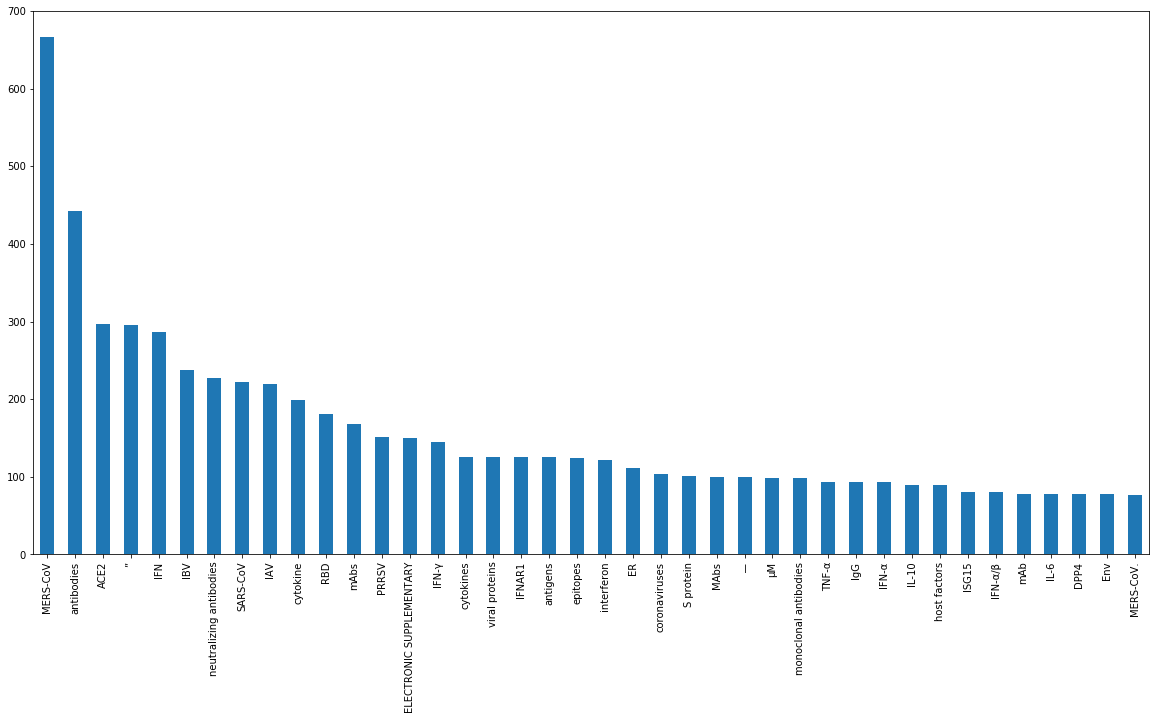

In [38]:
entity_label = 'PROTEIN'

idx_ent = np.where(s.str[1] == entity_label) # Change this string to see results for different entities

bp = s.str[0].iloc[idx_ent].value_counts().head(40)
bp.plot(kind='bar', figsize=(20,10))
plt.xticks(rotation=90)
plt.savefig("./visualization/NLP_entities_protein.png", dpi=100)
plt.show()

Interesting. We can observe serveral things in this plot:<br>
(1) MERS-CoV is the most common entity in the protein category. It is also a respiratory syndrom from the corona virus family. Thus it is probably referenced to in the literature when dealing with a novel virus of the corona family.<br>
(2) Antibodies are coming in at the second place.<br>
(3) We can see several proteins from the IFN family. They are related to regulating the immune system and immune system responses in fighting viral infections.<br>
(4) Unexpected results are quotation marks, dashes and ELECTRONIC SUPPLEMENTARY. These should be taken out in pre-processing as these are incorrectly classified as proteins.

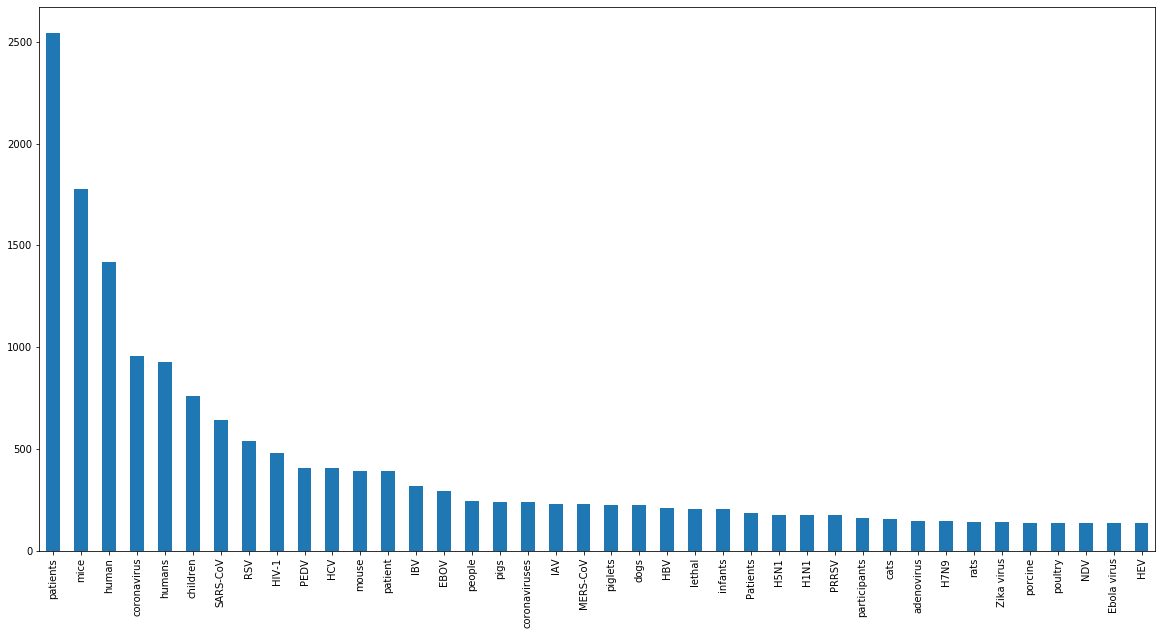

In [39]:
entity_label = 'ORGANISM'

idx_ent = np.where(s.str[1] == entity_label) # Change this string to see results for different entities

bp = s.str[0].iloc[idx_ent].value_counts().head(40)
bp.plot(kind='bar', figsize=(20,10))
plt.xticks(rotation=90)
plt.savefig("./visualization/NLP_entities_organism.png", dpi=100)
plt.show()

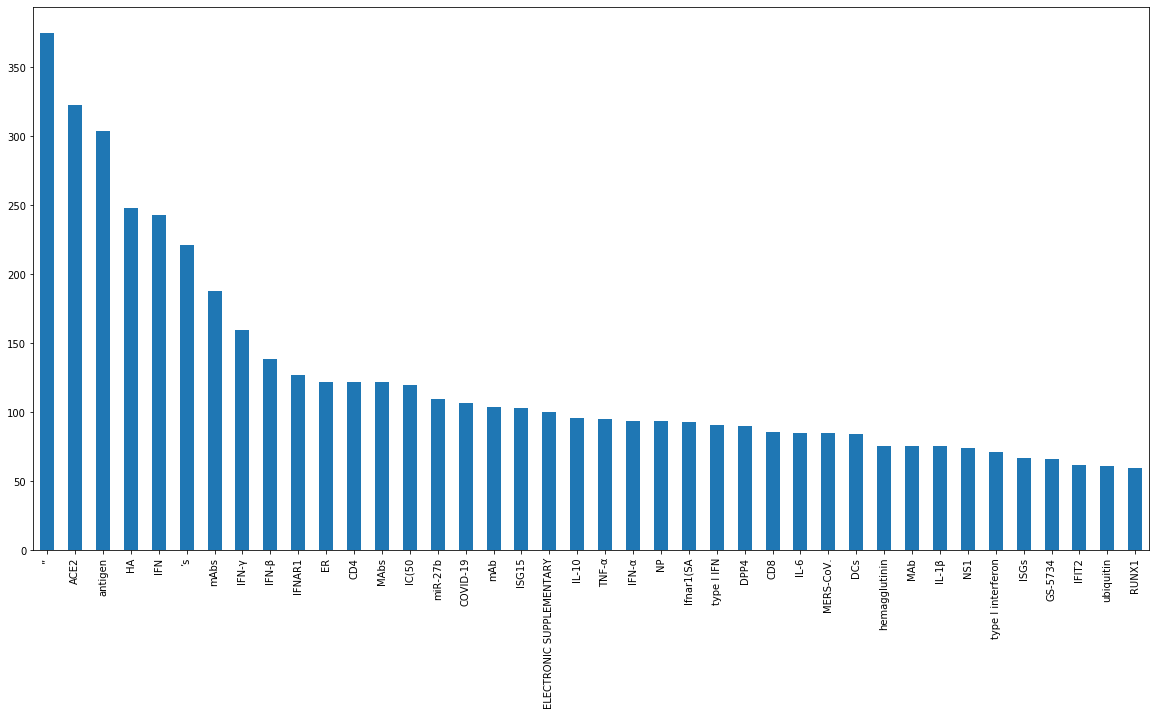

In [40]:
entity_label = 'GENE_OR_GENE_PRODUCT'

idx_ent = np.where(s.str[1] == entity_label) # Change this string to see results for different entities

bp = s.str[0].iloc[idx_ent].value_counts().head(40)
bp.plot(kind='bar', figsize=(20,10))
plt.xticks(rotation=90)
plt.savefig("./visualization/NLP_entities_geneproduct.png", dpi=100)
plt.show()

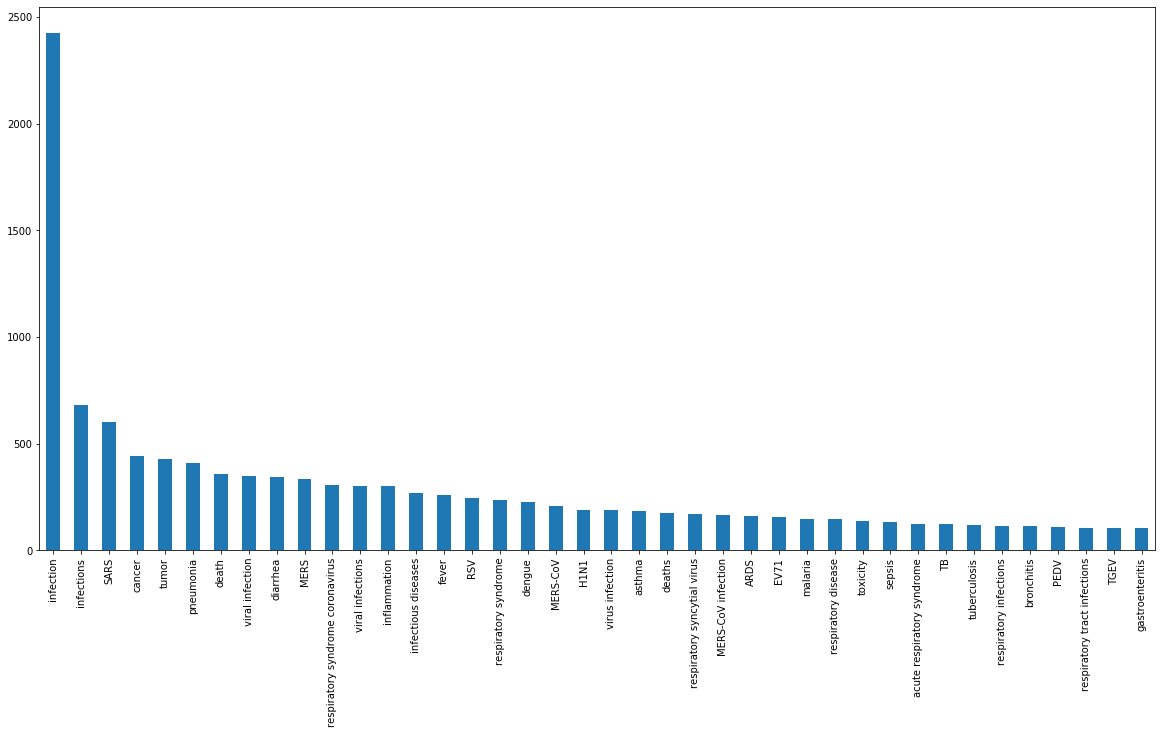

In [41]:
entity_label = 'DISEASE'

idx_ent = np.where(s.str[1] == entity_label) # Change this string to see results for different entities

bp = s.str[0].iloc[idx_ent].value_counts().head(40)
bp.plot(kind='bar', figsize=(20,10))
plt.xticks(rotation=90)
plt.savefig("./visualization/NLP_entities_disease.png", dpi=100)
plt.show()

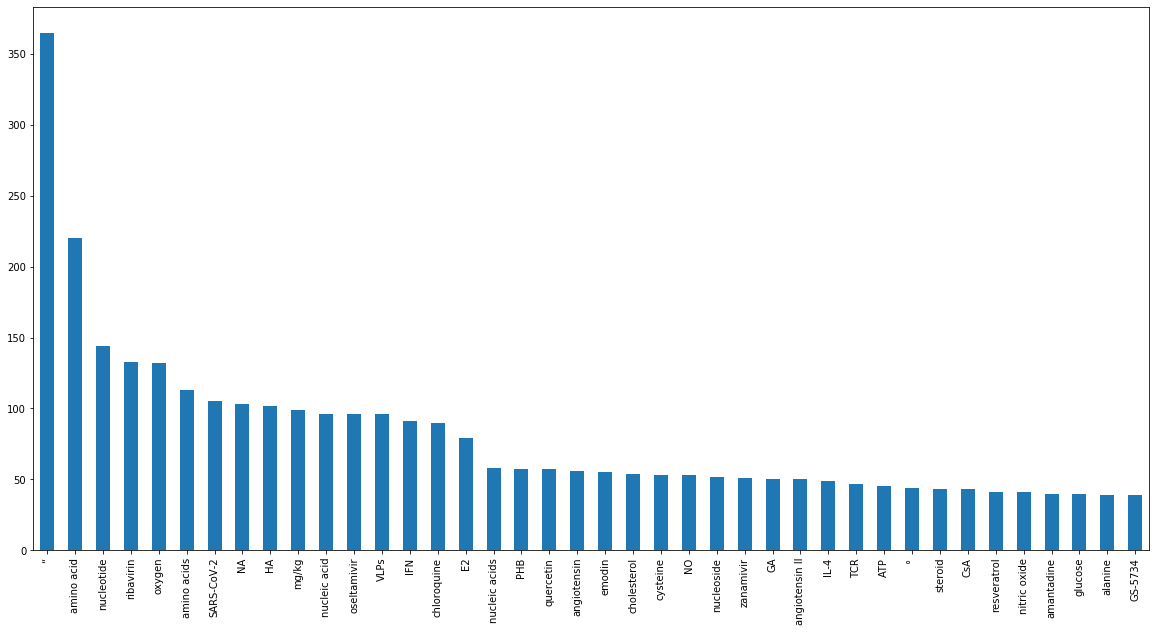

In [42]:
entity_label = 'CHEMICAL'

idx_ent = np.where(s.str[1] == entity_label) # Change this string to see results for different entities

bp = s.str[0].iloc[idx_ent].value_counts().head(40)
bp.plot(kind='bar', figsize=(20,10))
plt.xticks(rotation=90)
plt.savefig("./visualization/NLP_entities_chemical.png", dpi=100)
plt.show()

This is another interesting plot, because it contains some of the potential off-label drugs for corona virus, such as Ribavirin (4th) or Chloroquine (15th). Also, Oseltamivir (11th) is a flu drug which is used to treat and prevent the flu.<br>
However, we do not only see drug names in this list - in fact we can see an overlap with the "GENE OR GENE PRODUCT" entities or the "PROTEIN" entities. These should be due to the fact that these categories stem from three different NER models. 

In [43]:
# Look at abstracts with a certain keyword in them
keyword_of_interest = 'antibodies'
idx_of_interest = []

for i in range(vaccines[~vaccines.Entities.isna()].shape[0]):
    ls  = vaccines[~vaccines.Entities.isna()]['Entities'].iloc[i]
    
    for e in ls:
        if e[0] == keyword_of_interest:
            idx_of_interest.append(i)

In [44]:
b = vaccines.iloc[idx_of_interest[1]]['abstract']
doc = nlp_protein(b) # change the model to match the chosen entity category
spacy.displacy.render(doc, style='ent',jupyter=True)

By looking at an example, it becomes clear that our protein model picked up on many, but not all proteins. We would also expect MERS on line 5 to be highlighted.

Last but not least, let's take a look at how the abstracts cluster together. We compare the standard spacy model and the protein ner model and look a batch of 500 abstracts. In order for the abstract word2vec vector to perform best, we're using the pre-processed abstracts.

In [45]:
vaccines.abstract_description[0]

'december 2019 cases unidentified pneumonia history exposure huanan seafood market reported wuhan hubei province novel coronavirus sars cov-2 identified accountable disease human human transmission confirmed disease named covid-19 world health organization spread rapidly country world 18 february 2020 number confirmed cases reached 75,199 2009 fatalities covid-19 resulted lower case fatality rate 2.67 confirmed cases compared severe acute respiratory syndrome sars middle east respiratory syndrome mers symptom composition 45 fatality cases collected released official reports fever cough short breath chest tightness pain major comorbidities fatality cases include hypertension diabetes coronary heart disease cerebral infarction chronic bronchitis source virus pathogenesis disease unconfirmed specific therapeutic drug found chinese government initiated level-1 public health response prevent spread disease crucial speed development vaccines drugs treatment enable defeat covid-19 soon possib

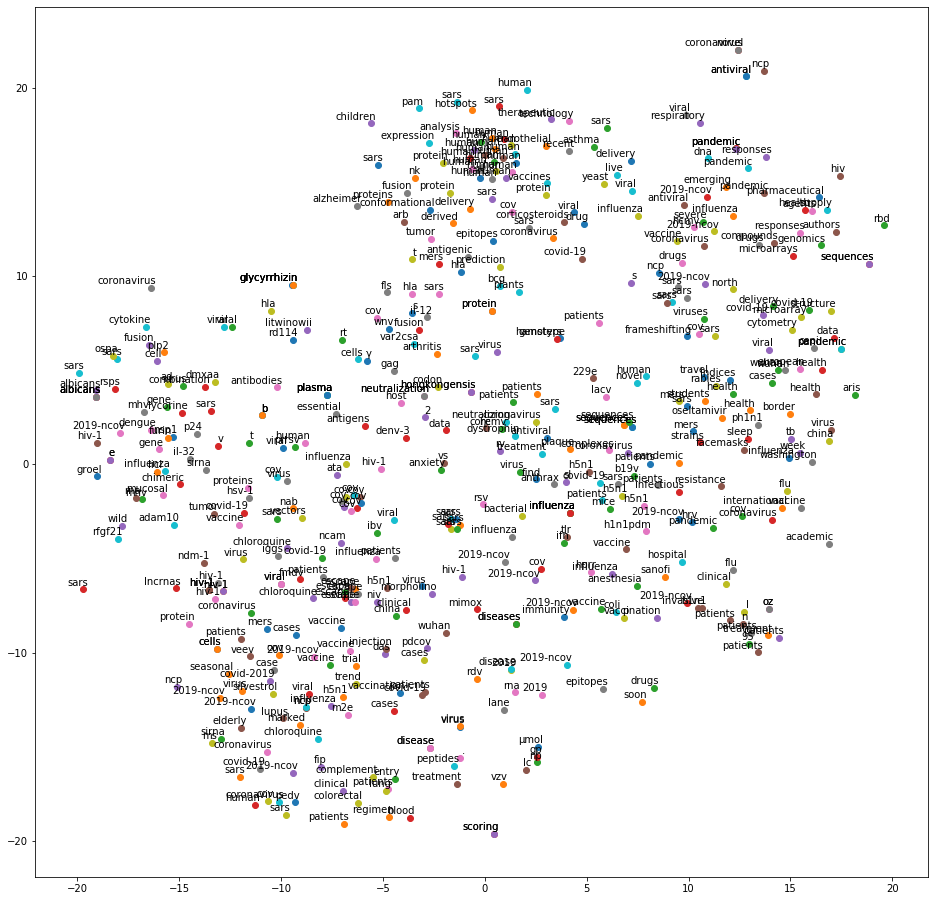

In [46]:
# Standard language model
labels = []
tokens = []

for abstract in vaccines.abstract_description[:500]: # for better readibility we just take 500 samples
    doc = nlp(abstract)
    tokens.append(doc.vector)
    words = [token.text for token in doc]
    most_common = Counter(words).most_common(1)[0][0]
    labels.append(most_common)
    
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
new_values = tsne_model.fit_transform(tokens)

x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])
        
plt.figure(figsize=(16, 16)) 
for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(labels[i],
                 xy=(x[i], y[i]),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
plt.savefig("./visualization/NLP_tsne_standardmodel.png", dpi=100)
plt.show()

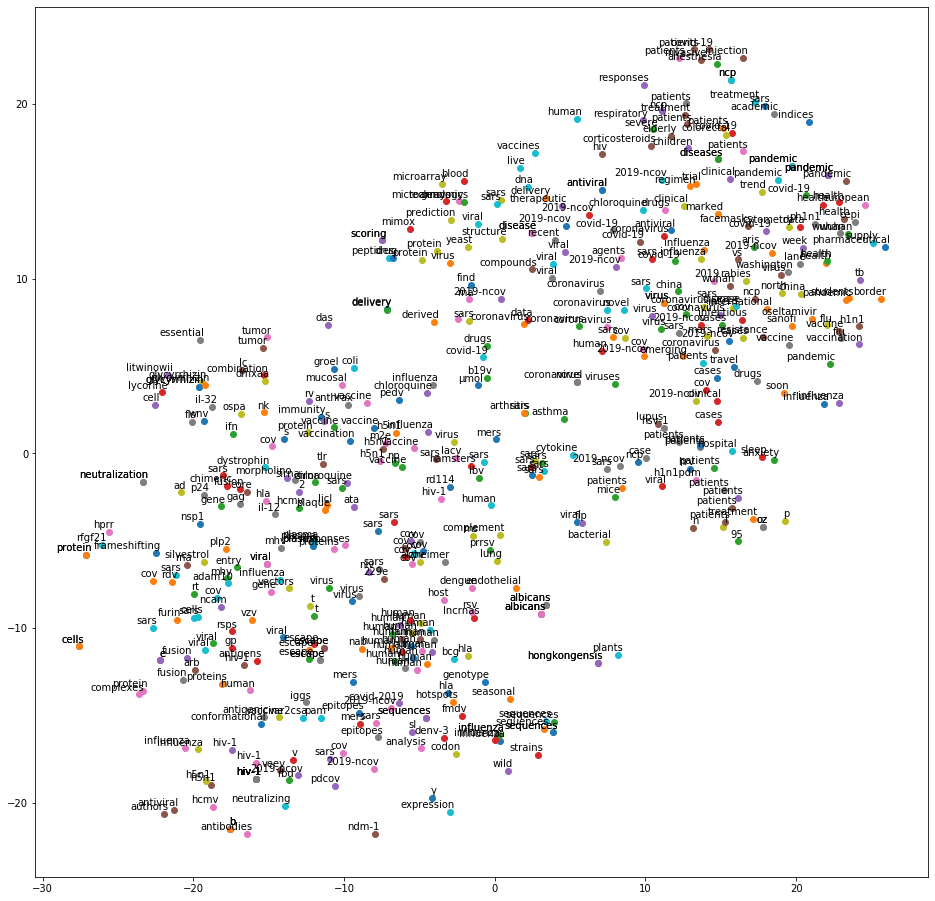

In [47]:
# Protein language model
labels = []
tokens = []

for abstract in vaccines.abstract_description[:500]: # for better readibility we just take 500 samples
    doc = nlp_protein(abstract)
    tokens.append(doc.vector)
    words = [token.text for token in doc]
    most_common = Counter(words).most_common(1)[0][0]
    labels.append(most_common)
    
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
new_values = tsne_model.fit_transform(tokens)

x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])
        
plt.figure(figsize=(16, 16)) 
for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(labels[i],
                 xy=(x[i], y[i]),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')

plt.savefig("./visualization/NLP_tsne_proteinmodel.png", dpi=100)
plt.show()

Using different language models results in different TSNE representations, due to the ner models generating different document vectors. In both cases though, we can see that clusters emerge around a documents most common word. Although this metric might be one indicator about what an article is about, it is not said that this is the ultimate metric to use.

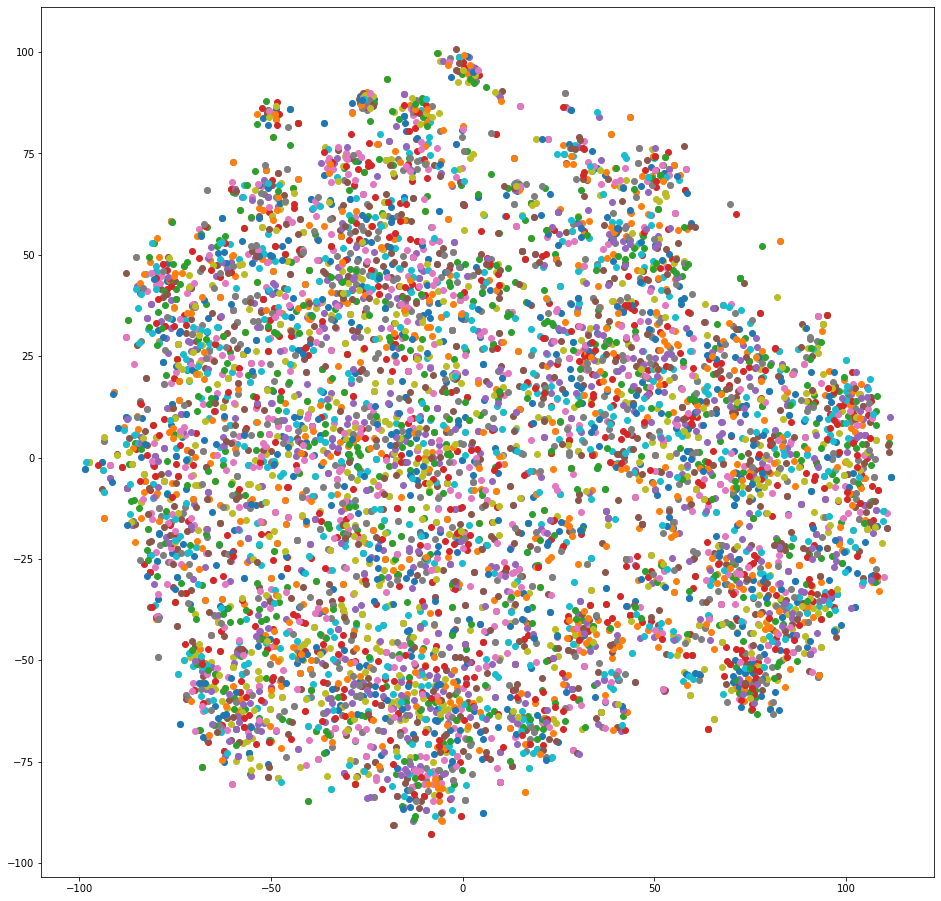

In [48]:
# Protein language model on all abstracts
labels = []
tokens = []

for abstract in vaccines.abstract_description: 
    doc = nlp_protein(abstract)
    tokens.append(doc.vector)
    
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
new_values = tsne_model.fit_transform(tokens)

x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])
        
plt.figure(figsize=(16, 16)) 
for i in range(len(x)):
    plt.scatter(x[i],y[i])
    
plt.savefig("./visualization/NLP_tsne_proteinmodel_complete.png", dpi=100)
plt.show()

CONCLUSION:<br>

We aimed to accomplish five objectives:
1. Reduce the number of abstracts to those that mention vaccines, therapies, or drug treatments. We started with a total of 26553 and were able to bring them down to 6666 relevant abstracts.<br>
2. We then looked at different NER models and their performance on sample documents. The medical models were generally more specific, but did not necessarily pick up on all relevant entities. In comparison, the small standard model recognized more entities in total.
3. We then looked at LDA topic models with different numbers of clusters. Because we do not know how many clusters to expect, it is hard to estimate the cluster parameter. We therefore showed how the results looked with ten, five, or three clusters.
4. Next, we took all three NER models to extract entities and visualized the top five categories (labels). Within each, we looked at the found entities to get a feeling of what has been mentioned in the abstracts. 
5. Lastly, we attempted to visualize the abstracts word vector using t-sne. Here again, we could make up some clusters and it would need further investigation to look at the abstracts in these clusters and test how similar they really are.
<br>
<br>
Things that would have to be further looked at: parameter tuning and practical use of these findings (probably with a subject matter expert with more knowledge of virology)